In [ ]:
from pathlib import Path
import patato as pat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from paiskintonetools import setup_matplotlib

from paiskintonetools.correction_factor import get_correction_factor_interpolator

setup_matplotlib(300)

In [4]:
unmixer = pat.SpectralUnmixer(
    chromophores=["Hb", "HbO2"], wavelengths=[700.0, 730.0, 760.0, 800.0, 850.0]
)
correct = False


correction_factor_spline = get_correction_factor_interpolator(
    "../Fluence Correction/cali_curve.csv"
)

df_scans = pd.read_parquet("../01_Prepare Data/scan_table.parquet")
df_scans = df_scans.query("SkinID=='SKIN36' and Region=='Carotid Artery'").set_index(
    "ScanNumber"
)[["ITA"]]

In [5]:
# wavelength = np.linspace(700, 900)
# mvf = np.logspace(np.log10(0.02), np.log10(0.4), 6)
# for i in mvf:
#     plt.plot(wavelength, np.exp(-correction_factor_spline((wavelength, i))))
# plt.show()

In [6]:
data_folder = Path("Data/SKIN36")
measurements = defaultdict(list)
measurements_corrected = defaultdict(list)

for f in data_folder.glob("*.hdf5"):
    pa = pat.PAData.from_hdf5(f)
    scan_number = int(f.stem.split("_")[-1])
    pa.set_default_recon(("Model Based", "0"))
    if scan_number not in df_scans.index:
        pa.scan_reader.file.close()
        continue
    ita = df_scans.loc[scan_number, "ITA"]
    if ("skin_", "0") not in pa.get_rois():
        pa.scan_reader.file.close()
        continue
    else:
        r = pa.get_rois()["skin_", "0"]
        rec = pa.get_scan_reconstructions()
        rec.raw_data = np.array(rec.raw_data)

        mask, _ = r.to_mask_slice(rec)

        mask[np.any(rec.raw_data[0, :4] < 0, axis=0)] = False

        thb = rec.raw_data[0, 0]
        print(thb.shape, mask.shape)

        measurements[pa.get_scan_name().split("-")[1]].append(np.mean(thb[mask]))

(400, 1, 400) (400, 1, 400)
(400, 1, 400) (400, 1, 400)


In [7]:
df_scans

,ITA
ScanNumber,
21,26.936667
18,1.090000


In [8]:
measurements

defaultdict(list,
            {'pigment': [0.01734499257299372],
             'nopigment': [0.008521532530505927]})

In [9]:
dfs = [pd.DataFrame(x) for x in [measurements]]
df = pd.concat(dfs, axis=1)

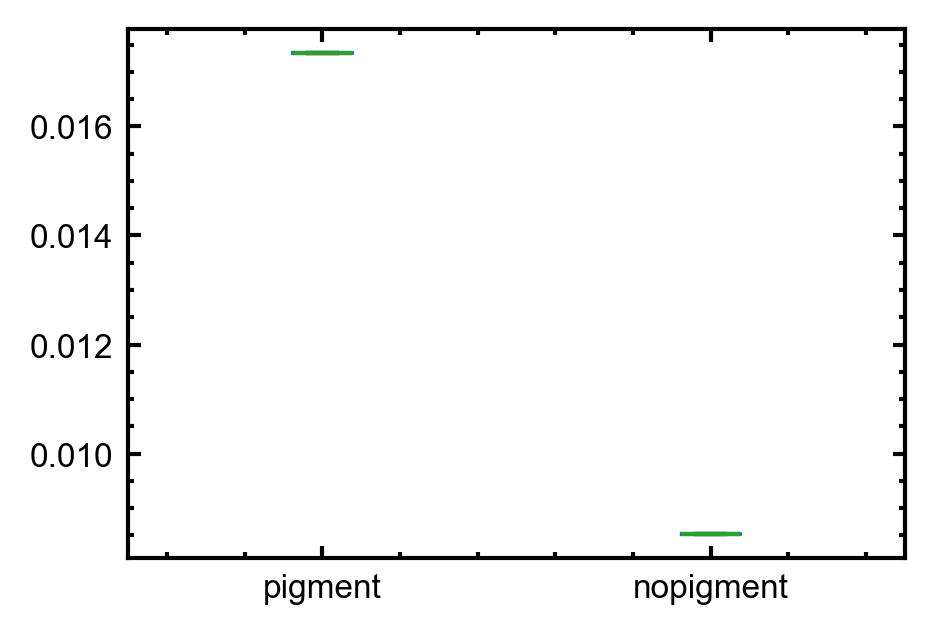

In [10]:
df.boxplot(grid=False, figsize=(3, 2), meanline=True)
# plt.plot([1, 2], [0.875+3.196/100, 0.875], c="C1")
plt.show()

In [11]:
m = dfs[0].mean()
s = dfs[0].std() / np.sqrt(3)
display(m)
display(s)

pigment      0.017345
nopigment    0.008522
dtype: float64

pigment     NaN
nopigment   NaN
dtype: float64

In [12]:
print(ttest_ind(dfs[0]["pigment"], dfs[0]["nopigment"]))

TtestResult(statistic=nan, pvalue=nan, df=0.0)


C:\Users\tomelse\Local\CambridgeBits\PAISKINTONE\.venv\Lib\site-packages\scipy\stats\_stats_py.py:6195: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [13]:
delta = m["pigment"] - m["nopigment"]
uncertainty = np.linalg.norm(s)

print(f"{delta:.2f}±{uncertainty:.2f}")

0.01±nan


In [14]:
predicted = 3.196
np.abs((predicted - delta) / uncertainty)

nan